Practical 1: The goal of this practical session is to build backprop from scratch and a small neural network (MLP).

Please return your notebook right at the end of the session.  You then have a week to return an updated version.

In [5]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
from graphviz import Digraph

In [7]:
# code to display a network - do not modify this cell
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [8]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+') 

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    
    out._backward = _backward
    return out

  def __mul__(self, other): 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    
    out._backward = _backward
    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, [self])

    def _backward():
      self.grad += other * (out.data**(other-1)) * out.grad
    
    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other 

  def __truediv__(self, other): # self / other
    out = self * other**-1

    def _backward():
      self.grad += 1.0 / other.data * out.grad
      other.grad -= self.data / (other.data ** 2) * out.grad
    
    out._backward = _backward
    return out

    return 

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data - other.data, (self, other), '-')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad -= 1.0 * out.grad
      
    out._backward = _backward
    return out


  def __radd__(self, other): # other + self
    return self + other

  def tanh(self): # TODO ex.3
    out = Value((1-math.exp(-2*self.data))/(1+math.exp(-2*self.data)), [self])

    def _backward():
      self.grad += (1 - (out.data)**2) * out.grad
    
    out._backward = _backward
    return out
    
  def exp(self): # ex.6
    out = Value(math.exp(self.data), [self])

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward    
    return out
    
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [9]:
# Exercise 1: fill in __add__ and __mul__ in the Value class to enable the following function. You should get -8.0 as a result.
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L

print(lol().data)

-8.0


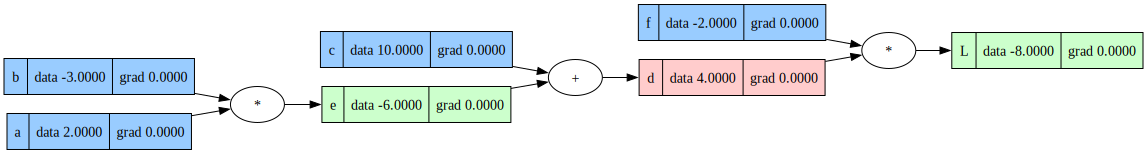

In [10]:
draw_dot(lol())

In [11]:
# Exercise 2: use the lol_grad() function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    b += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

In [12]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
# dL/df = 4.0
# dL/dd = 2
# dL/de = -2
# dL/dc = -2
# dL/da = 6
# dL/db = -4

lol_grad()


-4.000000000008441


In [13]:
# Exercise 3: implement the function tanh() in the Value class and build the following network
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



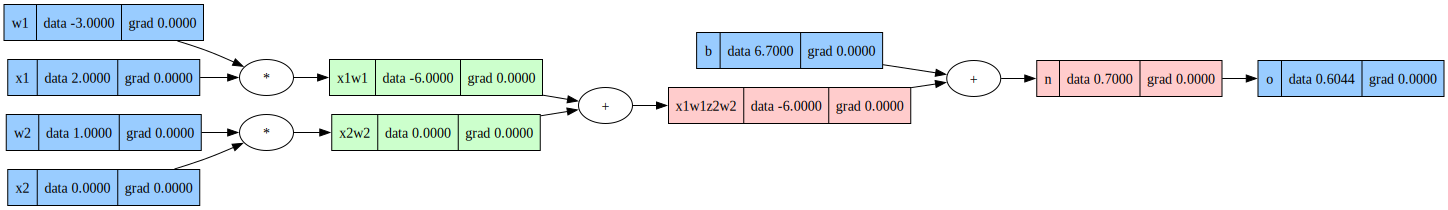

In [14]:
# o.data should be 0.6044
draw_dot(o)

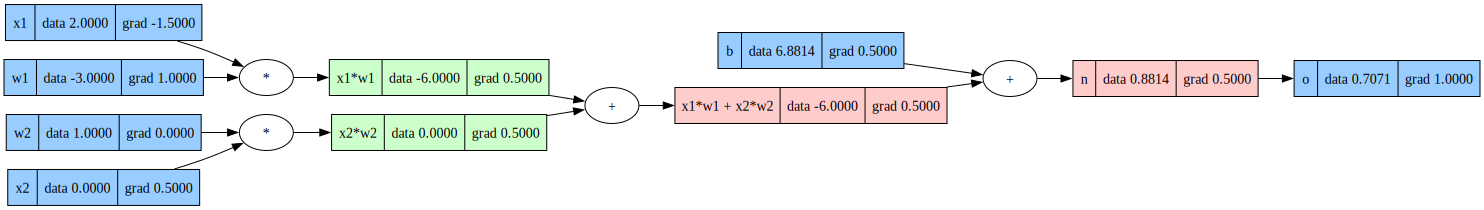

In [15]:
# Exercise 4: Implement the backward() function in each Value's operator: __add__, __mul__, __tanh__ and assign it to _backward
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
# e = (2*n).exp()
# o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward()
draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

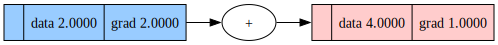

In [16]:
# Exercise 5: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. 
# Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?

a = Value(2)
b = a + a

b.backward()
draw_dot(b)

# At the beginning, the gradient of a is set to 0. Then, we create b = a + a, and we apply the backward propagation. We get b.grad = 1, and we know that both 'a' nodes in the graph contribute to the gradient accumulation.
# During the backward propagation, according to the formula, each 'a' node will have its gradient incremented by 1. MOreover, since the two nodes are linked thanks to the addiction operation, it will be also incremented by 1 again.
# At the end, we have a.grad = 2.
# However, if we just did self.grad = ... in the backwarde operation, the final value of a's gradient would only be 1, because we haven't involved them in two paths.

# So we use self.grad += because we are accumulating the gradient as we look back through the tree. 
# Each node in the graph accumulates the gradients of its children. If we only used self.grad = ..., we would overwrite the gradient each time we visited a new node, thus losing the contributions of the various paths in the graph.

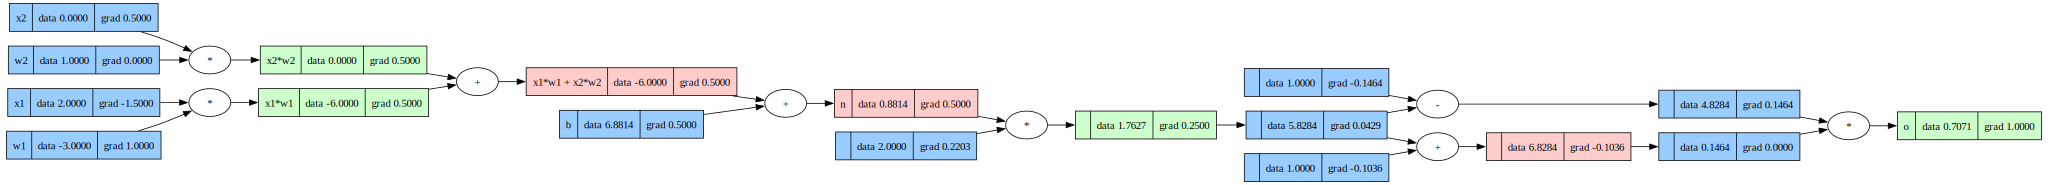

In [17]:
# Exercise 6: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = ... (no tanh allowed)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [18]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [19]:
# Exercise 7: Let's build an MLP based on the Value class. Fill in the Neuron, Layer and MLP classes.

In [20]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = np.array(self.w) @ np.array(x) + self.b
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    param = list()
    for neuron in self.neurons:
      param += neuron.parameters()
    return param

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    param = []
    for layer in self.layers:
      param += layer.parameters()
    return param

In [21]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
# nin = nb de valeurs d'entrée 
# nout = première valeur correspond au nombre de neurones dans la première couche cachée, la deuxième valeur correspond au nombre de neurones dans la deuxième couche cachée...
n(x)

Value(data=-0.9645515763584294)

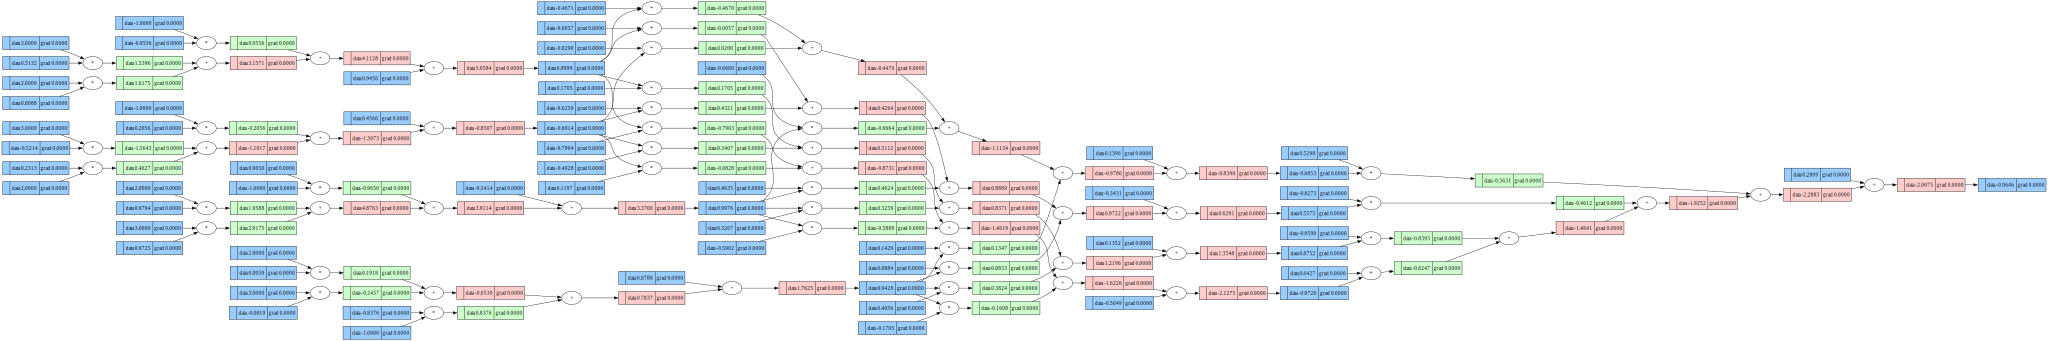

In [22]:
draw_dot(n(x))

In [23]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [24]:
len(n.parameters())

41

In [25]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9645515763584294),
 Value(data=-0.648153630109281),
 Value(data=-0.7879207631721722),
 Value(data=-0.8258355096868136)]

In [26]:
loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)])
loss

Value(data=7.361911675304447)

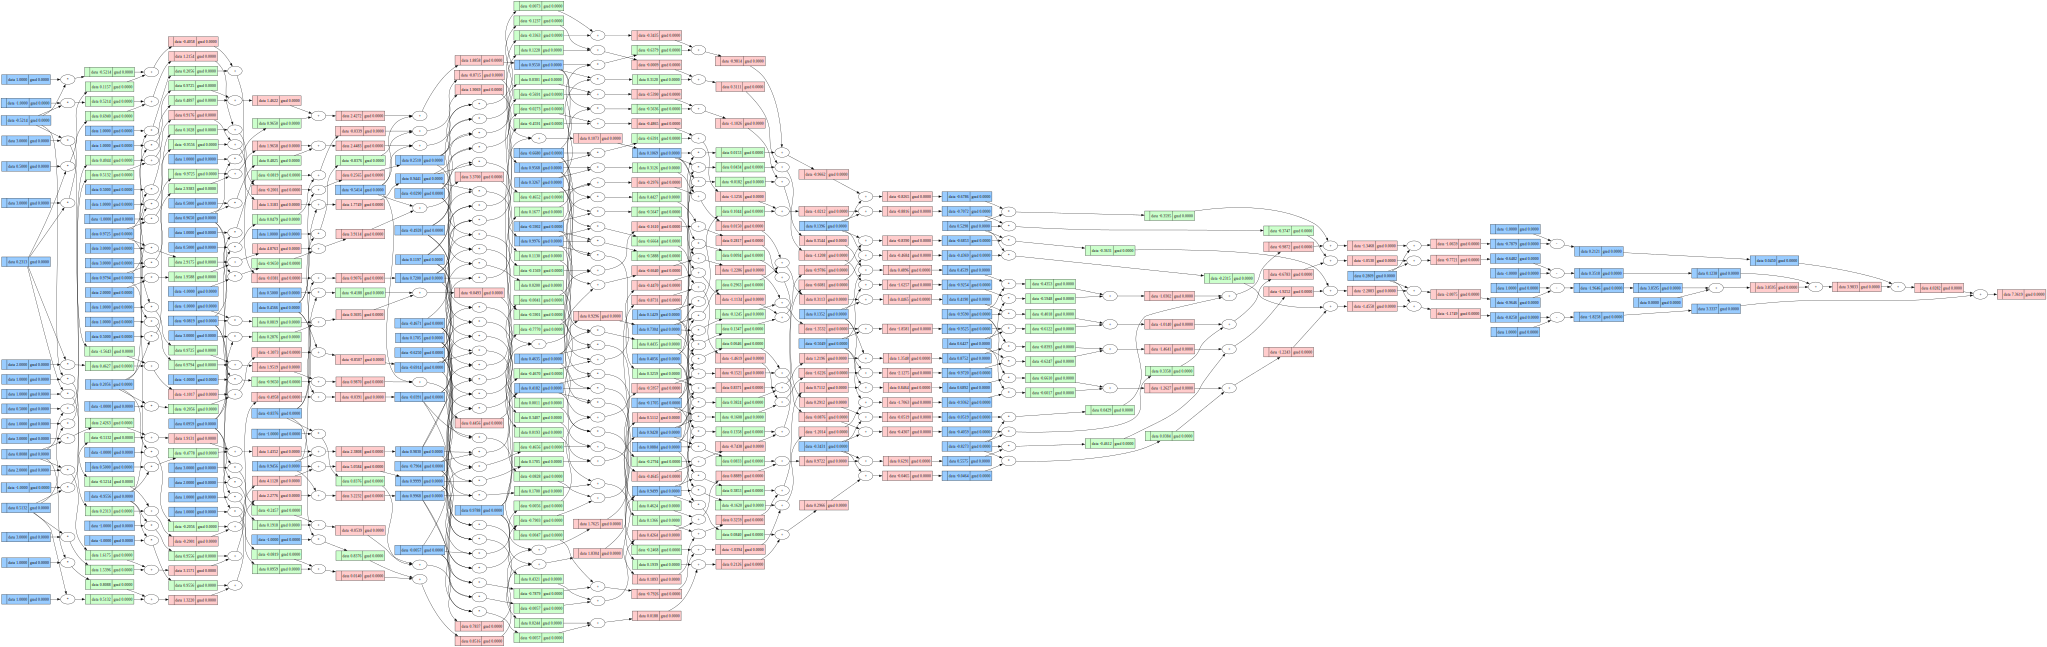

In [27]:
# see how a simple MLP can yield a complex graph already
draw_dot(loss)

In [28]:
# Exercise 8: write a training loop
for k in range(20):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss =  sum([(a-b)**2 for (a,b) in zip(ypred, ys)]) # MSE between ypred and ground-truth
    #backward pass 
    loss.backward()
    # update
    for param in n.parameters():
        print(param)
        param.data = param.data - 0.001 * param.grad
        param.grad = 0.0
    print(k, loss.data)

Value(data=0.2313328452071386)
Value(data=-0.5214440396442996)
Value(data=0.2056393490033832)
Value(data=0.4566373018568093)
Value(data=0.8087519732842203)
Value(data=0.5132059028125391)
Value(data=-0.9556447798025374)
Value(data=0.945618730114814)
Value(data=0.9794226294507)
Value(data=0.9724888290939098)
Value(data=0.9649608150693796)
Value(data=-0.5413872261542889)
Value(data=0.09588147179442741)
Value(data=-0.08188463280258795)
Value(data=-0.8375664305376056)
Value(data=0.9788090046529956)
Value(data=0.11971764310844102)
Value(data=-0.7904015311810615)
Value(data=-0.5901510827068905)
Value(data=-0.17052102553910098)
Value(data=-0.5048840306246634)
Value(data=-0.49276329026938015)
Value(data=0.17054634151713866)
Value(data=0.3266768008274956)
Value(data=0.40562951817332027)
Value(data=0.13522081643280193)
Value(data=-0.6249858910682247)
Value(data=-0.005685746555372351)
Value(data=0.46354005201789694)
Value(data=0.08839744254795012)
Value(data=-0.34308058987239054)
Value(data=-0.028

In [29]:
# Exercise 9: why do you need to reset the grads to zero at every training step? Answer as a comment in this cell.

# At each loop, we have to reset the grads to zero to have an effective backward pass which starts at a new point.

In [30]:
# Exercise 10: try to approximate the n^2 function with a 2-layer MLP.  why is it so hard?

In [35]:
xs = [[2.0], [3.0], [-1.0]]
ys = [x[0]**2 for x in xs] # desired targets
n = MLP(1, [4, 4, 1])

for k in range(20):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss =  sum([(a-b)**2 for (a,b) in zip(ypred, ys)]) # MSE between ypred and ground-truth
    #backward pass 
    loss.backward()
    # update
    for param in n.parameters():
        print(param)
        param.data = param.data - 0.001 * param.grad
        param.grad = 0.0
    print(k, loss.data)

Value(data=0.4226570124880151)
Value(data=0.0016455749275097187)
Value(data=-0.32316945747107506)
Value(data=0.9128796712046177)
Value(data=0.23317832591029286)
Value(data=0.47519867539123384)
Value(data=-0.3297754784283704)
Value(data=-0.24384247728484465)
Value(data=-0.7562355930854858)
Value(data=-0.0804731395282372)
Value(data=0.24846494863108748)
Value(data=0.2655444631208932)
Value(data=0.8990771814514447)
Value(data=-0.6580147901913505)
Value(data=-0.9649779648046339)
Value(data=-0.0035925046172418096)
Value(data=-0.7770238794225377)
Value(data=0.433388014689279)
Value(data=-0.2391631816141322)
Value(data=-0.31068792238293175)
Value(data=0.4700791068700616)
Value(data=0.651237857729041)
Value(data=-0.1463366094217644)
Value(data=-0.38277496776077635)
Value(data=0.1498324538011384)
Value(data=0.31128309207719385)
Value(data=0.04292101428488748)
Value(data=0.15051847450926914)
Value(data=-0.6079328759370242)
Value(data=0.7839302636579157)
Value(data=-0.30923474983717547)
Value(dat